# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
from nltk.corpus import stopwords
nltk.download(['punkt', 'wordnet','stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import set_config    # To change display

from sqlalchemy import create_engine

In [3]:
db_path = os.path.join(os.path.abspath('../data/'), 'DisasterResponse.db')
db_uri = 'sqlite:///{}'.format(db_path)

# load data from database
engine = create_engine(db_uri)
df = pd.read_sql_table('ResponseTable', con=engine)
df = df.set_index('id')
X = df['message']
y = df.iloc[:,3:]

In [4]:
df.head()

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    
    """
    Function for process the text data
    so that it is ready for the training
    
    Parameters:
    
    Text
    
    Returns:
    
    Cleaned data
    
    """

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
# Random Forest Classifier - MultiOutputClassifier pipeline
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_jobs=5)))
])

# LightGBM Classifier - MultiOutputClassifier pipeline
pipeline_lgb = Pipeline([
    ('tfidfvect', TfidfVectorizer(tokenizer=tokenize)),
    ('multiclassifier',MultiOutputClassifier(LGBMClassifier(n_jobs=5)))
])

# LightGBM Classifier - ClassifierChain pipeline
pipeline_chain_lgb = Pipeline([
    ('tfidfvect', TfidfVectorizer(tokenizer=tokenize)),
    ('classifierchain',ClassifierChain(LGBMClassifier(n_jobs=5)))
])

# LinearSVC Classifier - MultiOutputClassifier pipeline
pipeline_svc = Pipeline([
    ('tfidfvect', TfidfVectorizer(tokenizer=tokenize)),
    ('classifierchain',MultiOutputClassifier(LinearSVC(n_jobs=5)))
])

In [7]:
# Pipeline dictionary
pipeline_dict = {'pipeline_rf': pipeline_rf, \
                 'pipeline_lgb ': pipeline_lgb, \
                 'pipeline_chain_lgb': pipeline_chain_lgb \
                 'pipeline_svc': pipeline_svc
                 }

### 4. Train various pipelines
- Split data into train and test sets
- Train pipeline

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram') #'text'


def display_scores(model_dict, X_train, y_train):
    
    """
    Function for applying the cross validation score
    
    Parameters:
    
    models, X_train, y_train
    
    Returns:
    
    f1 - Scores and Average
    
    """
    
    # cross validation for F1 score
    results = {} 

    for pipename, pipevalue in pipeline_dict.items() :
        start_time = time.time()
        print ("Training pipeline : {} ...".format(pipename))
        scores = cross_val_score(pipevalue, X_train, y_train, scoring='f1_weighted', cv=5)
        results[pipename] = scores.mean()
        print ("Pipeline : {} F1 mean score {}".format(pipename, scores.mean()))
        time_taken = round(((time.time() - start_time) / 60),3)
        print("--- " + str(time_taken) + " minutes ---")
        
    return results

In [10]:
f1_scores = display_scores(pipeline_dict, X_train, y_train)

Training pipeline : pipeline_rf ...
Pipeline : pipeline_rf F1 mean score 0.5298388562808923
--- 7.057 minutes ---
Training pipeline : pipeline_lgb  ...
Pipeline : pipeline_lgb  F1 mean score 0.6547367307689326
--- 6.262 minutes ---
Training pipeline : pipeline_chain_lgb ...
Pipeline : pipeline_chain_lgb F1 mean score 0.6682756106393972
--- 6.634 minutes ---


In [11]:
f1_scores

{'pipeline_rf': 0.5298388562808923,
 'pipeline_lgb ': 0.6547367307689326,
 'pipeline_chain_lgb': 0.6682756106393972}

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

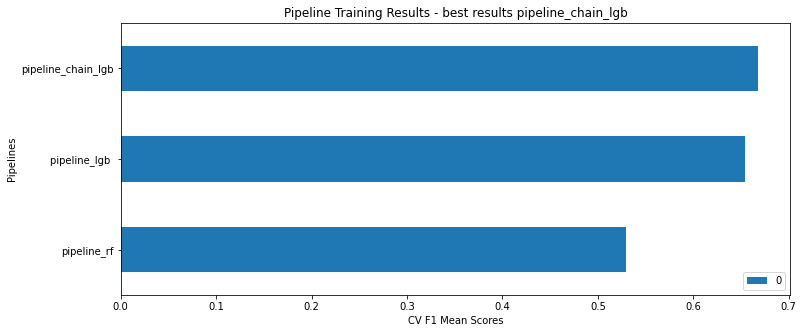

In [12]:
# Results and Best pipeline
best_pipeline_name = max(f1_scores, key=f1_scores.get)

ax = pd.DataFrame.from_dict(f1_scores, orient='index').plot.barh(figsize=(12,5))
ax.set_xlabel("CV F1 Mean Scores")
ax.set_ylabel("Pipelines")
ax.set_title('Pipeline Training Results - best results '+ best_pipeline_name)
plt.show()

In [13]:
# Train best pipline
best_pipeline = pipeline_dict[best_pipeline_name]

In [14]:
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fb4ec961680>)),
                ('classifierchain',
                 ClassifierChain(base_estimator=LGBMClassifier(n_jobs=5)))])

In [15]:
# predict on test data
y_pred = best_pipeline.predict(X_test)

# Print Classification Report
print(classification_report(y_test, y_pred, target_names= y_test.columns.to_list()))

                        precision    recall  f1-score   support

               related       0.86      0.93      0.89      3998
               request       0.77      0.65      0.71       891
                 offer       0.00      0.00      0.00        24
           aid_related       0.75      0.71      0.73      2164
          medical_help       0.61      0.42      0.50       435
      medical_products       0.65      0.35      0.46       279
     search_and_rescue       0.60      0.19      0.29       136
              security       0.27      0.03      0.06        96
              military       0.53      0.34      0.42       158
           child_alone       0.00      0.00      0.00         0
                 water       0.73      0.75      0.74       335
                  food       0.81      0.82      0.82       584
               shelter       0.72      0.66      0.69       468
              clothing       0.74      0.40      0.52        70
                 money       0.61      

### 6. Improve your model
Use grid search to find better parameters. 

In [16]:
myscoring = make_scorer(f1_score,average='weighted')

parameters = {
     'tfidfvect__ngram_range': ((1, 1), (1, 2), (2, 2)),
     'tfidfvect__max_df': (0.5, 0.75, 1.0)
    }

# create grid search object
search = GridSearchCV(best_pipeline, parameters, scoring=myscoring, verbose = 1)

result = search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [17]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.672235054615475
Best Hyperparameters: {'tfidfvect__max_df': 0.75, 'tfidfvect__ngram_range': (1, 2)}


In [18]:
#Print grid search CV results
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    display("param search results -> %f (%f) with: %r" % (mean, stdev, param))

"param search results -> 0.668166 (0.004723) with: {'tfidfvect__max_df': 0.5, 'tfidfvect__ngram_range': (1, 1)}"

"param search results -> 0.671516 (0.004658) with: {'tfidfvect__max_df': 0.5, 'tfidfvect__ngram_range': (1, 2)}"

"param search results -> 0.576116 (0.001740) with: {'tfidfvect__max_df': 0.5, 'tfidfvect__ngram_range': (2, 2)}"

"param search results -> 0.667534 (0.003455) with: {'tfidfvect__max_df': 0.75, 'tfidfvect__ngram_range': (1, 1)}"

"param search results -> 0.672235 (0.002893) with: {'tfidfvect__max_df': 0.75, 'tfidfvect__ngram_range': (1, 2)}"

"param search results -> 0.576116 (0.001740) with: {'tfidfvect__max_df': 0.75, 'tfidfvect__ngram_range': (2, 2)}"

"param search results -> 0.668276 (0.003332) with: {'tfidfvect__max_df': 1.0, 'tfidfvect__ngram_range': (1, 1)}"

"param search results -> 0.671781 (0.002836) with: {'tfidfvect__max_df': 1.0, 'tfidfvect__ngram_range': (1, 2)}"

"param search results -> 0.576116 (0.001740) with: {'tfidfvect__max_df': 1.0, 'tfidfvect__ngram_range': (2, 2)}"

In [19]:
# Best Model with tuned parameters
set_config(display='text')

best_model_tuned = search.best_estimator_
best_model_tuned

Pipeline(steps=[('tfidfvect',
                 TfidfVectorizer(max_df=0.75, ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x7fb4ec961680>)),
                ('classifierchain',
                 ClassifierChain(base_estimator=LGBMClassifier(n_jobs=5)))])

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [20]:
# Print Classification Report
predictions = best_model_tuned.predict(X_test)
print(classification_report(y_test, predictions, target_names= y_test.columns.to_list()))

                        precision    recall  f1-score   support

               related       0.86      0.93      0.89      3998
               request       0.75      0.67      0.71       891
                 offer       0.00      0.00      0.00        24
           aid_related       0.74      0.72      0.73      2164
          medical_help       0.58      0.44      0.50       435
      medical_products       0.63      0.37      0.47       279
     search_and_rescue       0.65      0.23      0.34       136
              security       0.24      0.05      0.09        96
              military       0.53      0.36      0.43       158
           child_alone       0.00      0.00      0.00         0
                 water       0.73      0.78      0.75       335
                  food       0.80      0.83      0.81       584
               shelter       0.71      0.66      0.69       468
              clothing       0.72      0.40      0.51        70
                 money       0.55      

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [21]:
## Please see step 3

### 9. Export your model as a pickle file

In [23]:
import pickle
from datetime import datetime

model_dir = '../models/'

model_file = 'classifier.pkl'
print("Saving model {} to directory {}".format(model_file,model_dir))
pickle.dump(best_model_tuned, open(model_dir+model_file, 'wb'))

Saving model classifier.pkl to directory ../models/


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.